In [48]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import pandas as pd
import plotly.express as px

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, TimeDistributed, Input, Activation, concatenate
from keras.callbacks import History
from keras.models import Model

# The values have around 15 decimals, so for more clarity in reading we're increasing the number of displayed values
pd.set_option('display.float_format', '{:.15f}'.format)

# 1. Importing the sensor and location data

## Full sensor data and location

In [2]:
full_sensor_and_loc_file = '../data/Processed/full_sensor_data_no_interpol_and_location.csv'

In [3]:
df_sensor_and_loc = pd.read_csv(full_sensor_and_loc_file, index_col=0)
df_sensor_and_loc

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:61,0.412078860000000,0.443542480000000,9.409470000000001,0.032653810000000,0.321075440000000,-0.377655030000000,NaN,NaN,NaN,9.428927012090160,0.496768589146909,NaN,NaN,NaN
12:15:51:62,0.378555300000000,0.465087900000000,9.435805999999999,0.018798828000000,0.324279800000000,-0.366989140000000,NaN,NaN,NaN,9.454842449217251,0.490093678290338,NaN,NaN,NaN
12:15:51:63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12:15:51:64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19:09:27:16,1.302719100000000,0.520156860000000,7.142166000000000,-0.118621826000000,-0.505569460000000,0.092132570000000,NaN,NaN,NaN,7.278610814164050,0.527408785424618,NaN,NaN,NaN
19:09:27:17,2.049713100000000,0.280731200000000,8.202788999999999,-0.301849370000000,-0.332992550000000,0.140075680000000,23.100280000000001,-16.200256000000000,-262.800599999999974,8.459662001373697,0.470763503951147,264.310852200404213,NaN,NaN
19:09:27:18,2.140686000000000,0.043701172000000,9.170044000000001,-0.590530400000000,0.304031370000000,0.046325684000000,23.100280000000001,-13.949585000000001,-261.749270000000024,9.416695455676912,0.665813259304968,263.136645496752351,NaN,NaN
19:09:27:19,1.896484400000000,-0.226837160000000,9.799728000000000,-0.686401370000000,0.651306150000000,-0.067657470000000,NaN,NaN,NaN,9.984126253738191,0.948643281224560,NaN,NaN,NaN


In [4]:
df_sensor_and_loc.loc[:, 'lat'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.loc[:, 'long'].interpolate(method='linear', inplace=True)
df_sensor_and_loc.dropna(inplace=True)
df_sensor_and_loc

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:68,0.752044700000000,0.659011840000000,9.081467000000000,0.064605710000000,0.363693240000000,-0.362731930000000,52.499389999999998,-50.399780000000000,-261.300659999999993,9.136351060907591,0.517707565743274,271.245937648577694,44.434937499999961,26.047602129736543
12:15:51:70,0.764022800000000,0.639862060000000,8.693603500000000,-0.093048096000000,0.537323000000000,-0.366989140000000,53.250121999999998,-49.650573999999999,-260.699459999999988,8.750536904096773,0.657308894946786,270.675014428439624,44.434937499999954,26.047602287170676
12:15:51:72,0.761627200000000,0.601547240000000,8.547561999999999,-0.231536870000000,0.496841430000000,-0.382980350000000,53.700256000000003,-51.600647000000002,-261.000060000000019,8.602485176829743,0.668681297196179,271.417345770840086,44.434937499999947,26.047602444604813
12:15:51:75,1.024993900000000,0.424377440000000,9.782973999999999,-0.580947900000000,0.266754150000000,-0.371261600000000,54.600524999999998,-48.300170000000001,-260.850520000000017,9.845673617954953,0.739251929108875,270.845191089993193,44.434937499999933,26.047602680756018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19:09:27:10,0.866973900000000,-0.753570560000000,11.801285000000000,1.092590300000000,0.211364750000000,-0.624786400000000,22.200012000000001,-11.099243000000000,-260.850520000000017,11.857058656488332,1.276239267074012,262.028676889083272,44.434937499964619,26.047602549477574
19:09:27:12,1.384124800000000,-0.945098900000000,10.108582000000000,1.477142300000000,0.371154800000000,-0.779251100000000,22.349547999999999,-12.449646000000000,-262.500000000000000,10.246582037122440,1.710829487957096,263.743712685875437,44.434937499964605,26.047602339565394
19:09:27:15,0.629943850000000,0.611129760000000,6.129410000000000,0.447036740000000,-0.437393200000000,-0.180572510000000,22.200012000000001,-14.100647000000000,-262.950130000000001,6.191928276862587,0.650969346193634,264.262066225244780,44.434937499964590,26.047602024697124
19:09:27:17,2.049713100000000,0.280731200000000,8.202788999999999,-0.301849370000000,-0.332992550000000,0.140075680000000,23.100280000000001,-16.200256000000000,-262.800599999999974,8.459662001373697,0.470763503951147,264.310852200404213,44.434937499964576,26.047601814784940


## 1.1. Full sensor data, no downsampling (so each 20ms)

In [5]:
full_data_no_downsample = df_sensor_and_loc.copy(deep=True)
# full_data_no_downsample.reset_index(inplace=True)
# full_data_no_downsample.drop(['index'], axis=1, inplace=True)
full_data_no_downsample.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:68,0.752044700000000,0.659011840000000,9.081467000000000,0.064605710000000,0.363693240000000,-0.362731930000000,52.499389999999998,-50.399780000000000,-261.300659999999993,9.136351060907591,0.517707565743274,271.245937648577694,44.434937499999961,26.047602129736543
12:15:51:70,0.764022800000000,0.639862060000000,8.693603500000000,-0.093048096000000,0.537323000000000,-0.366989140000000,53.250121999999998,-49.650573999999999,-260.699459999999988,8.750536904096773,0.657308894946786,270.675014428439624,44.434937499999954,26.047602287170676
12:15:51:72,0.761627200000000,0.601547240000000,8.547561999999999,-0.231536870000000,0.496841430000000,-0.382980350000000,53.700256000000003,-51.600647000000002,-261.000060000000019,8.602485176829743,0.668681297196179,271.417345770840086,44.434937499999947,26.047602444604813
12:15:51:75,1.024993900000000,0.424377440000000,9.782973999999999,-0.580947900000000,0.266754150000000,-0.371261600000000,54.600524999999998,-48.300170000000001,-260.850520000000017,9.845673617954953,0.739251929108875,270.845191089993193,44.434937499999933,26.047602680756018


In [6]:
# fig = px.scatter_geo(full_data_no_downsample,lat=full_data_no_downsample['lat'],lon=full_data_no_downsample['long'], hover_name=full_data_no_downsample.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=full_data_no_downsample['lat'][0], lon=full_data_no_downsample['long'][0])))
# fig.show()

In [7]:
full_data_no_downsample['a_total'][:500]

12:15:51:60    9.391328912221676
12:15:51:68    9.136351060907591
12:15:51:70    8.750536904096773
12:15:51:72    8.602485176829743
12:15:51:75    9.845673617954953
                     ...        
12:16:01:92    8.997484972412831
12:16:01:94    9.051022714918318
12:16:01:96    9.597954974363169
12:16:01:98   10.054459560869226
12:16:02:00   10.715059659136122
Name: a_total, Length: 500, dtype: float64

In [116]:
full_data_no_downsample['a_total'][:500].reset_index()

,index,a_total
0,12:15:51:60,9.391328912221676
1,12:15:51:68,9.136351060907591
2,12:15:51:70,8.750536904096773
3,12:15:51:72,8.602485176829743
4,12:15:51:75,9.845673617954953
...,...,...
495,12:16:01:92,8.997484972412831
496,12:16:01:94,9.051022714918318
497,12:16:01:96,9.597954974363169
498,12:16:01:98,10.054459560869226


Text(0, 0.5, 'm/s^2')

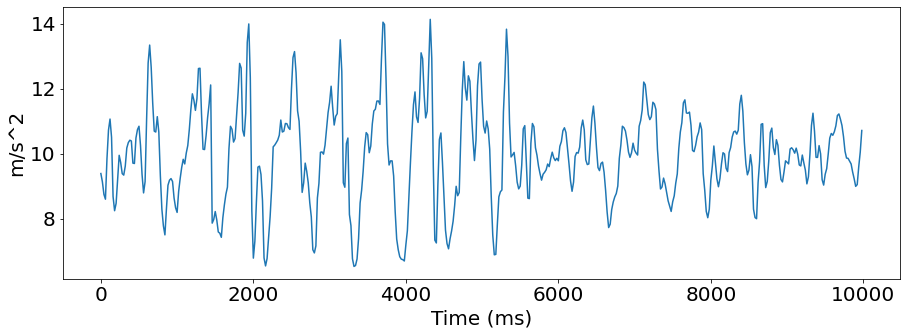

In [137]:
# [:500] = first 500 values, so 10 sec (20ms intervals * 500 values)
# plt.plot(full_data_no_downsample['a_total'][:500])
# plt.xlabel('Time')
# plt.ylabel('Magnitude')
font = {'family' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

a_total = full_data_no_downsample['a_total'][:500].reset_index()
a_total.drop(['index'], axis=1, inplace=True)
a_total.index = a_total.index * 20
a_total

fig = plt.figure(figsize=(15,5))
plt.plot(a_total)
plt.xlabel('Time (ms)')
plt.ylabel('m/s^2')

Text(0, 0.5, 'MICROtESLA')

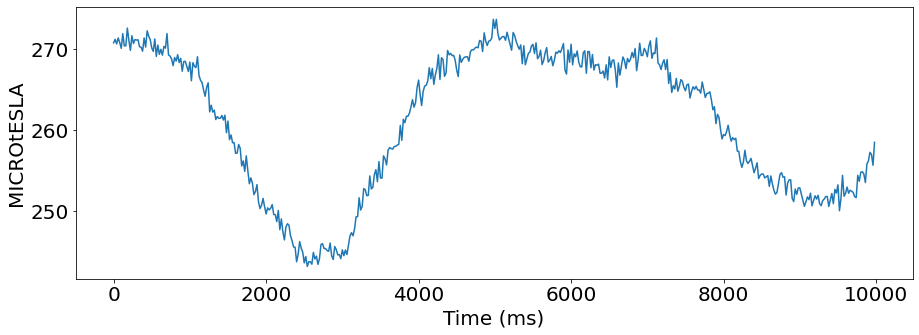

In [138]:
# plt.plot(full_data_no_downsample['m_total'][:500])
# plt.xlabel('Time')
# plt.ylabel('Magnitude rad/s')

font = {'family' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

a_total = full_data_no_downsample['m_total'][:500].reset_index()
a_total.drop(['index'], axis=1, inplace=True)
a_total.index = a_total.index * 20
a_total

fig = plt.figure(figsize=(15,5))
plt.plot(a_total)
plt.xlabel('Time (ms)')
plt.ylabel('MICROtESLA')

Text(0, 0.5, 'rad/s')

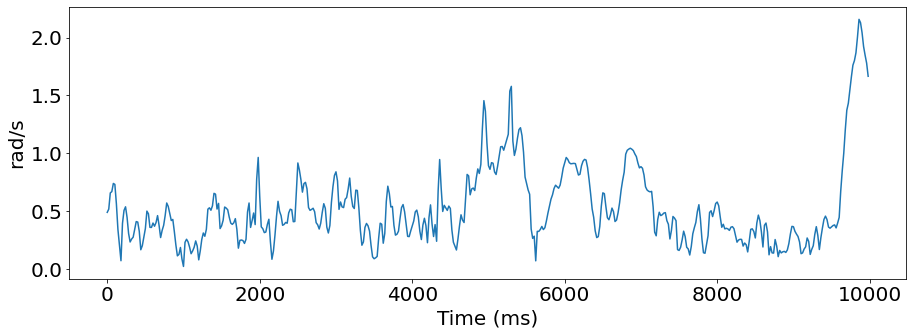

In [139]:
# plt.plot(full_data_no_downsample['g_total'][:500])
# plt.xlabel('Time')
# plt.ylabel('Magnitude')

font = {'family' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

a_total = full_data_no_downsample['g_total'][:500].reset_index()
a_total.drop(['index'], axis=1, inplace=True)
a_total.index = a_total.index * 20
a_total

fig = plt.figure(figsize=(15,5))
plt.plot(a_total)
plt.xlabel('Time (ms)')
plt.ylabel('rad/s')

In [11]:
full_data_no_downsample['a_total'][:50]

12:15:51:60    9.391328912221676
12:15:51:68    9.136351060907591
12:15:51:70    8.750536904096773
12:15:51:72    8.602485176829743
12:15:51:75    9.845673617954953
12:15:51:76   10.726869948670483
12:15:51:78   11.066321360529120
12:15:51:80   10.508028228192805
12:15:51:83    8.683353459810544
12:15:51:85    8.248150147601766
12:15:51:87    8.475925851722007
12:15:51:88    9.198929025941160
12:15:51:90    9.951652553811654
12:15:51:93    9.729157435682376
12:15:51:95    9.388306281815559
12:15:51:96    9.343509067538880
12:15:51:99    9.620033003129889
12:15:52:01   10.176374870824478
12:15:52:03   10.342567608224693
12:15:52:05   10.416135746701174
12:15:52:07   10.392453861959124
12:15:52:09    9.711754260480602
12:15:52:11    9.699779170008044
12:15:52:13   10.482588044681426
12:15:52:15   10.742580127721808
12:15:52:17   10.845766009535598
12:15:52:19   10.247456520216732
12:15:52:21    9.366638241359848
12:15:52:23    8.796073865978615
12:15:52:25    9.141871719398011
12:15:52:2

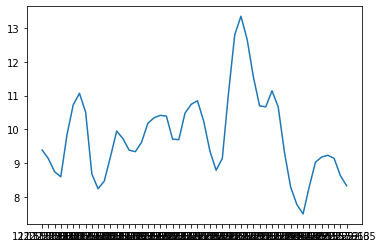

In [12]:
# [:100] = first 100 values, so 1 sec (10ms intervals * 100 values)
plt.plot(full_data_no_downsample['a_total'][:50])

## 1.x. Full sensor data, downsampled by 5 (so each 100ms)

In [13]:
full_data_downsample_5 = df_sensor_and_loc.copy(deep=True)[::5]
full_data_downsample_5.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:76,0.986679100000000,0.407623300000000,10.673614499999999,-0.573486300000000,0.265686040000000,-0.366989140000000,55.050660000000001,-50.250244000000002,-259.649659999999983,10.726869948670483,0.730860203470206,270.136276954078710,44.434937499999926,26.047602759473087
12:15:51:87,1.343414300000000,1.456283600000000,8.241104000000000,-0.245376590000000,-0.293579100000000,-0.097488400000000,55.650329999999997,-49.349975999999998,-260.699459999999988,8.475925851722007,0.394844712528100,271.102541125311234,44.434937499999876,26.047603625360832
12:15:51:96,1.092025800000000,1.726821900000000,9.117386000000000,-0.080261230000000,-0.214752200000000,-0.044219970000000,54.899597000000000,-48.899839999999998,-261.000060000000019,9.343509067538880,0.233486141329103,271.157134191213231,44.434937499999840,26.047604333814444
12:15:52:07,1.060897800000000,1.839355500000000,10.173218000000000,0.218002320000000,-0.320205700000000,0.119827270000000,55.650329999999997,-47.850037000000000,-261.300659999999993,10.392453861959124,0.405481536538380,271.412269778736913,44.434937499999791,26.047605199702190


### Plot 10 sec

In [14]:
full_data_downsample_5['a_total'][:100]

12:15:51:60    9.391328912221676
12:15:51:76   10.726869948670483
12:15:51:87    8.475925851722007
12:15:51:96    9.343509067538880
12:15:52:07   10.392453861959124
                     ...        
12:16:01:52    9.367917249977816
12:16:01:61   10.567139388577322
12:16:01:72   11.063522949556594
12:16:01:81    9.858935668581209
12:16:01:92    8.997484972412831
Name: a_total, Length: 100, dtype: float64

Text(0, 0.5, 'm/s^2')

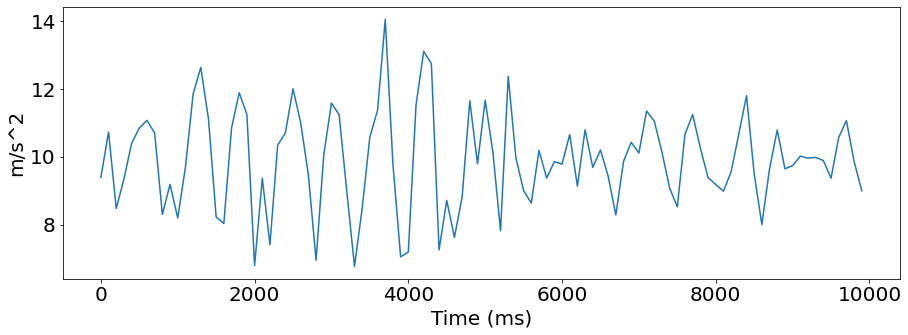

In [127]:
# [:100] = first 100 values, so 10 sec (100ms intervals * 100 values)
# plt.plot(full_data_downsample_5['a_total'][:100])
# plt.xlabel('Time')
# plt.ylabel('Magnitude')

font = {'family' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

a_total = full_data_downsample_5['a_total'][:100].reset_index()
a_total.drop(['index'], axis=1, inplace=True)
a_total.index = a_total.index * 100
a_total

fig = plt.figure(figsize=(15,5))
plt.plot(a_total)
plt.xlabel('Time (ms)')
plt.ylabel('m/s^2')

Text(0, 0.5, 'rad/s')

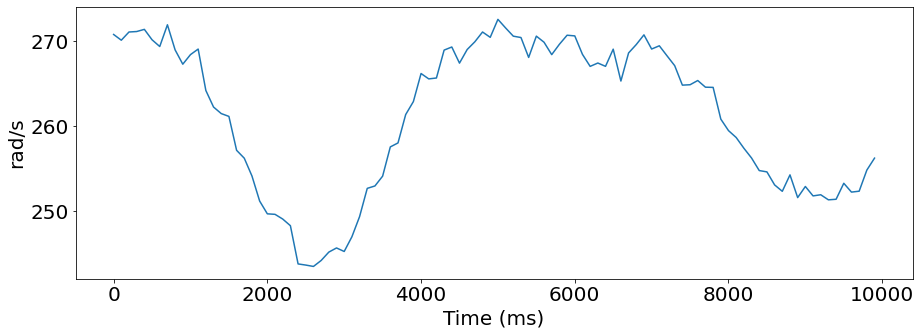

In [131]:
# plt.plot(full_data_downsample_5['m_total'][:100])
# plt.xlabel('Time')
# plt.ylabel('Magnitude')

font = {'family' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

a_total = full_data_downsample_5['m_total'][:100].reset_index()
a_total.drop(['index'], axis=1, inplace=True)
a_total.index = a_total.index * 100
a_total

fig = plt.figure(figsize=(15,5))
plt.plot(a_total)
plt.xlabel('Time (ms)')
plt.ylabel('microTesla')

Text(0, 0.5, 'rad/s')

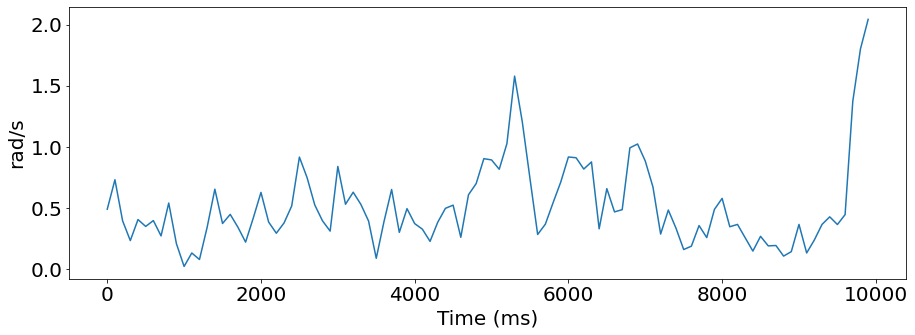

In [141]:
# plt.plot(full_data_downsample_5['g_total'][:100])
# plt.xlabel('Time')
# plt.ylabel('Magnitude')

font = {'family' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

a_total = full_data_downsample_5['g_total'][:100].reset_index()
a_total.drop(['index'], axis=1, inplace=True)
a_total.index = a_total.index * 100
a_total

fig = plt.figure(figsize=(15,5))
plt.plot(a_total)
plt.xlabel('Time (ms)')
plt.ylabel('rad/s')

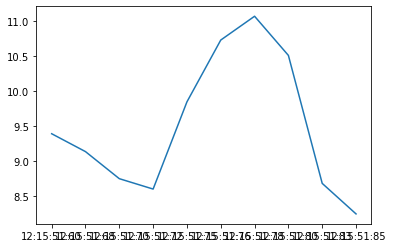

In [18]:
# [:100] = first 100 values, so 1 sec (10ms intervals * 100 values)
plt.plot(full_data_no_downsample['a_total'][:10])

## 1.2. Full sensor data, downsampled by 10 (so each 200ms)

In [19]:
full_data_downsample_10 = df_sensor_and_loc.copy(deep=True)[::10]
full_data_downsample_10.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:51:87,1.343414300000000,1.456283600000000,8.241104000000000,-0.245376590000000,-0.293579100000000,-0.097488400000000,55.650329999999997,-49.349975999999998,-260.699459999999988,8.475925851722007,0.394844712528100,271.102541125311234,44.434937499999876,26.047603625360832
12:15:52:07,1.060897800000000,1.839355500000000,10.173218000000000,0.218002320000000,-0.320205700000000,0.119827270000000,55.650329999999997,-47.850037000000000,-261.300659999999993,10.392453861959124,0.405481536538380,271.412269778736913,44.434937499999791,26.047605199702190
12:15:52:27,0.146316530000000,-0.353729250000000,11.063858000000000,-0.285858150000000,0.275268550000000,-0.012268066000000,57.150269999999999,-50.100707999999997,-258.450319999999977,11.070478162817576,0.397036726240666,269.393396747723841,44.434937499999705,26.047606774043548
12:15:52:47,0.246871950000000,0.060470580000000,8.296173000000000,0.378860470000000,0.111221310000000,0.369094850000000,57.600403000000000,-52.049255000000002,-257.550049999999999,8.300065595925814,0.540496479010973,268.996207458060496,44.434937499999620,26.047608348384905


In [20]:
# fig = px.scatter_geo(full_data_downsample_10,lat=full_data_downsample_10['lat'],lon=full_data_downsample_10['long'], hover_name=full_data_downsample_10.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=full_data_downsample_10['lat'][0], lon=full_data_downsample_10['long'][0])))
# fig.show()

### Plot 10 sec

In [21]:
full_data_downsample_10['a_total'][:50]

12:15:51:60    9.391328912221676
12:15:51:87    8.475925851722007
12:15:52:07   10.392453861959124
12:15:52:27   11.070478162817576
12:15:52:47    8.300065595925814
12:15:52:67    8.196174022235169
12:15:52:87   11.842575648210891
12:15:53:07   11.112256185219367
12:15:53:37    8.033543304241077
12:15:53:59   11.883922764197155
12:15:53:80    6.790697078556858
12:15:54:00    7.412604056833074
12:15:54:20   10.694275259076507
12:15:54:40   10.999004672173760
12:15:54:62    6.950718720451248
12:15:54:82   11.580659648240989
12:15:55:07    8.969662875655942
12:15:55:27    8.482996146907462
12:15:55:47   11.368204921277698
12:15:55:68    9.781091126568221
12:15:55:88    7.193137705660286
12:15:56:08   13.103074182416204
12:15:56:28    7.257174862701250
12:15:56:48    7.626277459518166
12:15:56:68   11.647857664389230
12:15:56:88   11.661681695500542
12:15:57:08    7.823250858622852
12:15:57:28    9.964548686532927
12:15:57:48    8.635340345891558
12:15:57:69    9.370389187582932
12:15:57:8

Text(0, 0.5, 'm/s^2')

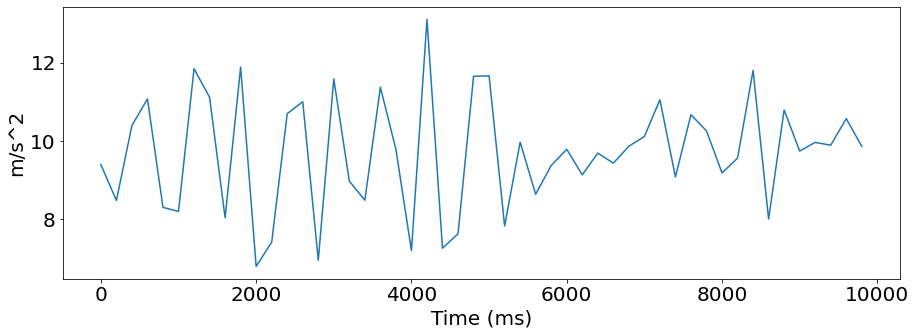

In [130]:
# [:100] = first 100 values, so 10 sec (100ms intervals * 100 values)
# plt.plot(full_data_downsample_10['a_total'][:10])
# plt.xlabel('Time')
# plt.ylabel('Magnitude')

font = {'family' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

a_total = full_data_downsample_10['a_total'][:50].reset_index()
a_total.drop(['index'], axis=1, inplace=True)
a_total.index = a_total.index * 200
a_total

fig = plt.figure(figsize=(15,5))
plt.plot(a_total)
plt.xlabel('Time (ms)')
plt.ylabel('m/s^2')

Text(0, 0.5, 'rad/s')

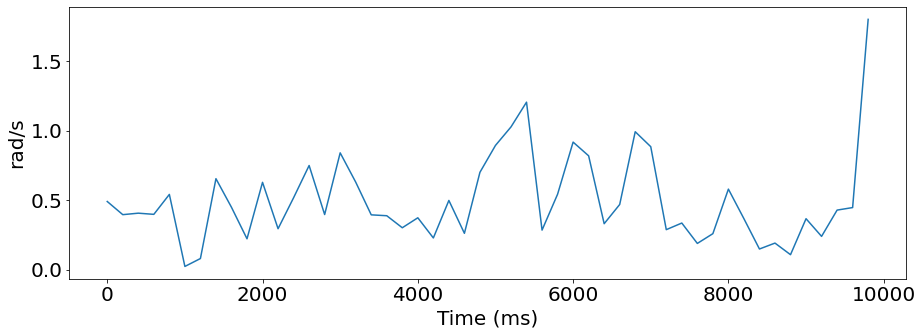

In [142]:
# plt.plot(full_data_downsample_10['m_total'][:10])
# plt.xlabel('Time')
# plt.ylabel('Magnitude')

font = {'family' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

a_total = full_data_downsample_10['g_total'][:50].reset_index()
a_total.drop(['index'], axis=1, inplace=True)
a_total.index = a_total.index * 200
a_total

fig = plt.figure(figsize=(15,5))
plt.plot(a_total)
plt.xlabel('Time (ms)')
plt.ylabel('rad/s')

Text(0, 0.5, 'Magnitude')

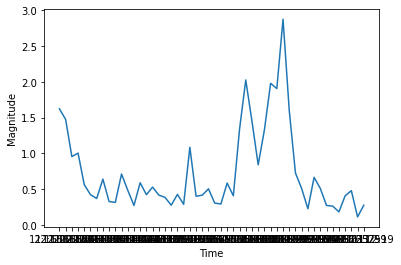

In [24]:
# plt.plot(full_data_downsample_10['g_total'][50:100])
# plt.xlabel('Time')
# plt.ylabel('Magnitude')
font = {'family' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

a_total = full_data_downsample_10['g_total'][:100].reset_index()
a_total.drop(['index'], axis=1, inplace=True)
a_total.index = a_total.index * 100
a_total

fig = plt.figure(figsize=(15,5))
plt.plot(a_total)
plt.xlabel('Time (ms)')
plt.ylabel('rad/s')

### Plot for 1 sec

In [25]:
full_data_downsample_10['a_total'][:5]

12:15:51:60    9.391328912221676
12:15:51:87    8.475925851722007
12:15:52:07   10.392453861959124
12:15:52:27   11.070478162817576
12:15:52:47    8.300065595925814
Name: a_total, dtype: float64

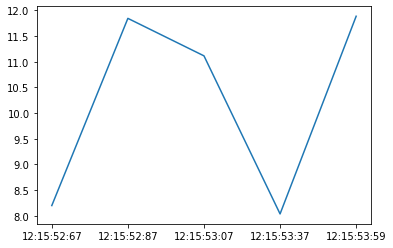

In [26]:
# [:10] = first 10 values, so 1 sec (100ms intervals * 10 values)
plt.plot(full_data_downsample_10['a_total'][5:10])

## 1.3. Full sensor data, downsampled by 50 (so each 1000ms)

In [27]:
full_data_downsample_50 = df_sensor_and_loc.copy(deep=True)[::50]
full_data_downsample_50.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:52:67,-0.023666382000000,0.295089720000000,8.190825999999999,-0.013153076000000,-0.017669678000000,0.001586914100000,57.150269999999999,-51.150512999999997,-257.249450000000024,8.196174022235169,0.022084818886426,268.439579545451124,44.434937499999528,26.047609922726263
12:15:53:80,1.151886000000000,-0.056854248000000,6.692047000000000,0.492843630000000,-0.135925300000000,0.363769530000000,55.799866000000002,-34.649659999999997,-240.899660000000011,6.790697078556858,0.627454222846645,249.693552523586760,44.434937499998888,26.047621651569376
12:15:54:82,1.453552200000000,1.037292500000000,11.442154000000000,0.199890140000000,-0.203033450000000,0.789886500000000,35.249330000000000,-14.999390000000000,-242.250059999999991,11.580659648240989,0.839701930907850,245.260246546040520,44.434937499998185,26.047634498194853
12:15:55:88,0.002670288000000,0.426773070000000,7.180465700000000,-0.258163450000000,-0.036849976000000,-0.265792850000000,17.999268000000001,-19.349670000000000,-264.900199999999984,7.193137705660286,0.372360211029892,266.215137318832262,44.434937499997332,26.047649989713815


In [28]:
# fig = px.scatter_geo(full_data_downsample_50,lat=full_data_downsample_50['lat'],lon=full_data_downsample_50['long'], hover_name=full_data_downsample_50.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=full_data_downsample_50['lat'][0], lon=full_data_downsample_50['long'][0])))
# fig.show()

### Plot 10 sec

In [29]:
full_data_downsample_50['a_total'][:20]

12:15:51:60    9.391328912221676
12:15:52:67    8.196174022235169
12:15:53:80    6.790697078556858
12:15:54:82   11.580659648240989
12:15:55:88    7.193137705660286
12:15:56:88   11.661681695500542
12:15:57:89    9.783615422598119
12:15:58:92   10.109858746592996
12:15:59:96    9.181033335856243
12:16:01:01    9.738292601767126
12:16:02:02   10.640104072921000
12:16:03:03    9.221974690544092
12:16:04:03   11.402955026658631
12:16:05:08   10.449237993979736
12:16:06:15   10.698217865383810
12:16:07:17    7.122663325541986
12:16:08:18    9.083931086589049
12:16:09:19   11.169606989268452
12:16:10:25    9.794886787724970
12:16:11:33    7.288060395856029
Name: a_total, dtype: float64

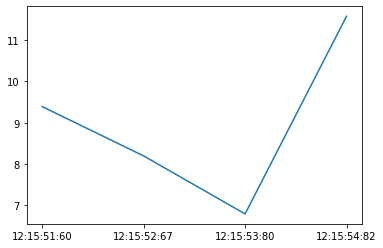

In [30]:
# [:20] = first 20 values, so 10 sec (500ms intervals * 20 values)
plt.plot(full_data_downsample_50['a_total'][:4])

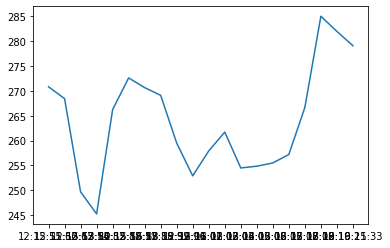

In [31]:
plt.plot(full_data_downsample_50['m_total'][:20])

### Plot 1 sec

In [32]:
full_data_downsample_50['a_total'][:2]

12:15:51:60   9.391328912221676
12:15:52:67   8.196174022235169
Name: a_total, dtype: float64

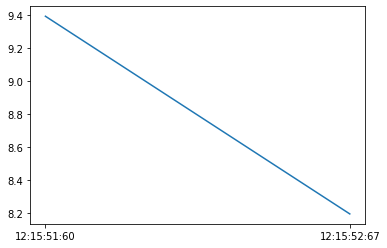

In [33]:
plt.plot(full_data_downsample_50['a_total'][:2])

## 1.4. Full sensor data, downsampled by 100 (so each 1000ms)

In [34]:
full_data_downsample_100 = df_sensor_and_loc.copy(deep=True)[::100]
full_data_downsample_100.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:53:80,1.151886000000000,-0.056854248000000,6.692047000000000,0.492843630000000,-0.135925300000000,0.363769530000000,55.799866000000002,-34.649659999999997,-240.899660000000011,6.790697078556858,0.627454222846645,249.693552523586760,44.434937499998888,26.047621651569376
12:15:55:88,0.002670288000000,0.426773070000000,7.180465700000000,-0.258163450000000,-0.036849976000000,-0.265792850000000,17.999268000000001,-19.349670000000000,-264.900199999999984,7.193137705660286,0.372360211029892,266.215137318832262,44.434937499997332,26.047649989713815
12:15:57:89,0.668258670000000,0.417205800000000,9.751846000000000,0.062484740000000,0.241180420000000,0.882553100000000,24.600220000000000,-48.899839999999998,-265.049739999999986,9.783615422598119,0.917045425289202,270.643178096440465,44.434937499996295,26.047668773234840
12:15:59:96,-0.224792480000000,-0.327392580000000,9.172440000000000,-0.182525630000000,-0.315948500000000,-0.449020400000000,24.600220000000000,-52.650449999999999,-252.900700000000001,9.181033335856243,0.578583079492744,259.491820236671231,44.434937499995819,26.047677908033894


In [35]:
# fig = px.scatter_geo(full_data_downsample_100,lat=full_data_downsample_100['lat'],lon=full_data_downsample_100['long'], hover_name=full_data_downsample_100.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=full_data_downsample_100['lat'][0], lon=full_data_downsample_100['long'][0])))
# fig.show()

In [36]:
full_data_downsample_100['a_total'][:10]

12:15:51:60    9.391328912221676
12:15:53:80    6.790697078556858
12:15:55:88    7.193137705660286
12:15:57:89    9.783615422598119
12:15:59:96    9.181033335856243
12:16:02:02   10.640104072921000
12:16:04:03   11.402955026658631
12:16:06:15   10.698217865383810
12:16:08:18    9.083931086589049
12:16:10:25    9.794886787724970
Name: a_total, dtype: float64

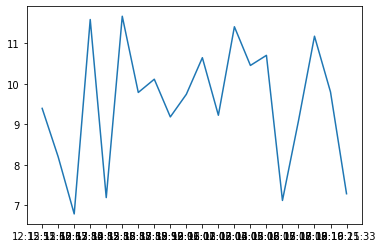

In [37]:
# [:10] = first 10 values, so 10 sec (1000ms intervals * 10 values)
plt.plot(full_data_downsample_50['a_total'][:20])

## 1.5. Full sensor data, downsampled by 200 (so each 2000ms)

In [38]:
full_data_downsample_200 = df_sensor_and_loc.copy(deep=True)[::200]
full_data_downsample_200.head()

,ax,ay,az,gx,gy,gz,mx,my,mz,a_total,g_total,m_total,lat,long
12:15:51:60,0.558120700000000,0.496215820000000,9.361587999999999,0.074188230000000,0.290191650000000,-0.387237550000000,52.349854000000001,-50.549315999999997,-260.850520000000017,9.391328912221676,0.489558992696751,270.811252251747476,44.434937499999997,26.047601499999999
12:15:55:88,0.002670288000000,0.426773070000000,7.180465700000000,-0.258163450000000,-0.036849976000000,-0.265792850000000,17.999268000000001,-19.349670000000000,-264.900199999999984,7.193137705660286,0.372360211029892,266.215137318832262,44.434937499997332,26.047649989713815
12:15:59:96,-0.224792480000000,-0.327392580000000,9.172440000000000,-0.182525630000000,-0.315948500000000,-0.449020400000000,24.600220000000000,-52.650449999999999,-252.900700000000001,9.181033335856243,0.578583079492744,259.491820236671231,44.434937499995819,26.047677908033894
12:16:04:03,1.314682000000000,1.796264600000000,11.183578499999999,-0.472290040000000,-0.339386000000000,-0.411743160000000,31.950378000000001,-52.799987999999999,-246.899409999999989,11.402955026658631,0.712582043477091,254.495548184032316,44.434919176317941,26.047683365750601
12:16:08:18,-0.832916260000000,0.046096800000000,9.045547500000000,0.434249880000000,0.749313350000000,1.832778900000000,11.549377000000000,-42.750549999999997,-262.950130000000001,9.083931086589049,2.027096926901486,266.652898918064523,44.434874747332493,26.047683365750601


In [39]:
# fig = px.scatter_geo(full_data_downsample_200,lat=full_data_downsample_200['lat'],lon=full_data_downsample_200['long'], hover_name=full_data_downsample_200.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=full_data_downsample_200['lat'][0], lon=full_data_downsample_200['long'][0])))
# fig.show()

# 2. Importing the ground truth data

In [40]:
position_file = '../data/Processed/partial_4_ground_truth.csv'
position_df = pd.read_csv(position_file, index_col=0)
position_df

,lat,long
11:05:09:00,44.434918000000003,26.047605999999998
11:05:10:60,44.434917999999307,26.047618594726657
11:05:11:60,44.434917999998618,26.047631189453320
11:05:12:40,44.434917999997921,26.047643784179972
11:05:13:20,44.434917999997225,26.047656378906638
...,...,...
13:04:50:40,44.434937499967326,26.047651878840107
13:04:51:20,44.434937499966637,26.047639284109248
13:04:52:20,44.434937499965947,26.047626689378390
13:04:53:20,44.434937499965251,26.047614094647528


In [41]:
# fig = px.scatter_geo(position_df,lat=position_df['lat'],lon=position_df['long'], hover_name=position_df.index)
# fig.update_layout(title = 'World map', title_x=0.5, geo = dict(projection_scale=800000, center=dict(lat=position_df['lat'][0], lon=position_df['long'][0])))
# fig.show()

In [42]:
data = {'c1': [1, 2, 3, 4], 'c2': [6, 10, 11, 22]}
df1 = pd.DataFrame(data)

In [43]:
sc = MinMaxScaler(feature_range=(0, 1))
data1_scaled = sc.fit_transform(df1)

In [44]:
data1_scaled

array([[0.        , 0.        ],
       [0.33333333, 0.25      ],
       [0.66666667, 0.3125    ],
       [1.        , 1.        ]])

In [45]:
data1_descaled = sc.inverse_transform(data1_scaled)

In [46]:
data1_descaled

array([[ 1.,  6.],
       [ 2., 10.],
       [ 3., 11.],
       [ 4., 22.]])